# Tornadic Activity Analysis and Classification

Analysis: Creating visualisations to analyse the times, months, years, and areas in which significant amounts of tornadic activity occur. 

Classification: Random Forest model with GridSearch (to find best params) to predict the classification of a tornado based on the month, time of day (hour), injuries, fatalities, property loss, crop loss, width of tornado, length traveled, and number of states affected. Produced feature importance chart. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns 
import numpy as np 
from statistics import mode

import folium

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 
from collections import Counter 

#sklearn imports for clustering, making machine learning model (classification model), and displaying metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, 
f1_score, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

#tensorflow/keras imports for deep learning model 
import tensorflow as tf 
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LSTM
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

https://www.spc.noaa.gov/wcm/#data

https://www.spc.noaa.gov/wcm/data/SPC_severe_database_description.pdf 

yr = 4-digit year </br>
mo = Month (1-12) </br>
dy = Day of month </br>
date = Datetime object (e.g., 1950-01-01) </br>
st = State where tornado originated; 2 letter abbr </br>
mag = F rating thru Jan 2007; EF rating after Jan 2007 (-9 if unknown) </br>
inj = Number of injuries </br>
fat = Number of fatalities </br>
slat = Starting latitude in decimal degrees </br>
slon = Starting longitude </br>
elat = Ending latitude in decimal degrees (value 0 if missing) </br>
elon = Enging longitude in decimal degrees (value 0 if missing) </br>
len = length of track in miles </br>
wid = width in yards </br>
loss = property loss </br>
clos = estimated crop loss in millions of dollars (0 doesn't mean $0)

In [3]:
#reading csv file into dataframe
tornadoUS = pd.read_csv("1950-2022_all_tornadoes.csv")

In [4]:
#calling dataframe object to get initial view of data
tornadoUS

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,15.80,10,1,1,1,25,0,0,0,0
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,2.00,880,1,1,1,47,0,0,0,0
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,0.10,10,1,1,1,177,0,0,0,0
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,0.10,10,1,1,1,209,0,0,0,0
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,2.00,37,1,1,1,101,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70032,621922,2022,9,28,2022-09-28,13:32:00,3,FL,12,0,...,3.00,100,1,1,1,9,0,0,0,0
70033,621923,2022,9,30,2022-09-30,10:25:00,3,NC,37,0,...,0.74,20,1,1,1,19,0,0,0,0
70034,621924,2022,9,30,2022-09-30,13:22:00,3,NC,37,0,...,0.70,12,1,1,1,13,0,0,0,0
70035,621900,2022,9,4,2022-09-04,15:44:00,3,OH,39,0,...,0.07,15,1,1,1,99,0,0,0,0


In [5]:
#dropping unneeded columns
tornadoUS = tornadoUS.drop(columns = ['om','stn', 'stf', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4', 'fc'])

In [6]:
#casting time column to datatime hour - time does not need to be precise to minutes 
tornadoUS['time'] = pd.to_datetime(tornadoUS['time'], format = '%H:%M:%S').dt.hour

In [7]:
#displaying column info - datatypes and non-nulls 
tornadoUS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70037 entries, 0 to 70036
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      70037 non-null  int64  
 1   mo      70037 non-null  int64  
 2   dy      70037 non-null  int64  
 3   date    70037 non-null  object 
 4   time    70037 non-null  int32  
 5   tz      70037 non-null  int64  
 6   st      70037 non-null  object 
 7   mag     70037 non-null  int64  
 8   inj     70037 non-null  int64  
 9   fat     70037 non-null  int64  
 10  loss    70037 non-null  float64
 11  closs   70037 non-null  float64
 12  slat    70037 non-null  float64
 13  slon    70037 non-null  float64
 14  elat    70037 non-null  float64
 15  elon    70037 non-null  float64
 16  len     70037 non-null  float64
 17  wid     70037 non-null  int64  
 18  ns      70037 non-null  int64  
dtypes: float64(7), int32(1), int64(9), object(2)
memory usage: 9.9+ MB


In [8]:
#renaming columns for clarity
tornadoUS = tornadoUS.rename(columns={'mag': 'rating', 'loss': 'property_loss', 'closs':'crop_loss', 'fat':'fatalities', 'inj':'injuries', 'st':'state', 'ns':'no_states'})

In [9]:
#checking names of columns have changed
tornadoUS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70037 entries, 0 to 70036
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   yr             70037 non-null  int64  
 1   mo             70037 non-null  int64  
 2   dy             70037 non-null  int64  
 3   date           70037 non-null  object 
 4   time           70037 non-null  int32  
 5   tz             70037 non-null  int64  
 6   state          70037 non-null  object 
 7   rating         70037 non-null  int64  
 8   injuries       70037 non-null  int64  
 9   fatalities     70037 non-null  int64  
 10  property_loss  70037 non-null  float64
 11  crop_loss      70037 non-null  float64
 12  slat           70037 non-null  float64
 13  slon           70037 non-null  float64
 14  elat           70037 non-null  float64
 15  elon           70037 non-null  float64
 16  len            70037 non-null  float64
 17  wid            70037 non-null  int64  
 18  no_sta

In [10]:
#getting the count, mean, std, min, max etc for each column
tornadoUS.describe()

,yr,mo,dy,time,tz,rating,injuries,fatalities,property_loss,crop_loss,slat,slon,elat,elon,len,wid,no_states
count,70037.000000,70037.000000,70037.000000,70037.000000,70037.000000,70037.000000,70037.000000,70037.000000,7.003700e+04,7.003700e+04,70037.000000,70037.000000,70037.000000,70037.000000,70037.000000,70037.000000,70037.000000
mean,1991.907449,5.961706,15.927595,15.078658,3.000942,0.693062,1.591387,0.103574,1.167887e+05,9.353414e+02,37.065396,-92.545709,23.164546,-57.293412,3.640879,111.664749,1.026657
std,19.604266,2.452622,8.759895,4.964374,0.071689,1.366599,20.165515,1.617390,8.900026e+06,6.735795e+04,5.320515,9.519852,18.482178,45.192460,8.620172,214.755167,0.165454
min,1950.000000,1.000000,1.000000,0.000000,0.000000,-9.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-163.530000,0.000000,-163.530000,0.000000,0.000000,0.000000
25%,1976.000000,4.000000,8.000000,13.000000,3.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,33.180000,-98.350000,0.000000,-94.730000,0.140000,20.000000,1.000000
50%,1995.000000,6.000000,16.000000,16.000000,3.000000,1.000000,0.000000,0.000000,1.000000e-01,0.000000e+00,36.980000,-93.470000,32.680000,-84.923600,0.850000,50.000000,1.000000
75%,2008.000000,7.000000,24.000000,18.000000,3.000000,1.000000,0.000000,0.000000,4.000000e+00,0.000000e+00,40.900000,-86.657200,38.694000,0.000000,3.420000,100.000000,1.000000
max,2022.000000,12.000000,31.000000,23.000000,9.000000,5.000000,1740.000000,158.000000,1.550000e+09,1.225000e+07,61.020000,0.000000,61.020000,0.000000,234.700000,4576.000000,3.000000


In [11]:
def nullDetect(tornadoDF, columnName): 
    '''
    columnName: Name of the column that the function is run on 

    Creates list called missingIndex to store indices - global as is used by another function 
    Uses index function to get the index of any null values in specified column and stores to list 
    '''
    global missingIndex
    missingIndex = []
    #gets the index of empty values in specified column
    missingIndex = tornadoDF.index[(tornadoDF[columnName].isnull())].tolist()

def zeroDetect(tornadoDF, columnName, value): 
    global zeroIndex
    zeroIndex = []
    #gets the index of empty values in specified column
    zeroIndex = tornadoDF.index[(tornadoDF[columnName] <= value)].tolist()
    tornadoDF.drop(zeroIndex, inplace = True)

def missingVals(tornadoDF, columnName, basisCol, dataType):
    '''
    columnName: Name of the column that the function is run on 
    basisCol: Column that will be used to get the basis value 

    Uses the missingIndex list to get the basis value from the specified column
    Calculates the mean of all instances of data in the original column with the same basis value in the specified basis column 
        and saves to a variable called newVal
        Example: if the police_force is 99, it finds all instances where the police_force is 99 and calculates the mean of those instances
    If the value within the index of the specified row and column is empty, it is replaced with the value in the newVal variable
    '''
    #https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-in-pandas
    nullDetect(tornadoDF, basisCol, columnName)
    for each in missingIndex: 
        basisVal = tornadoDF.loc[each, basisCol]
        newVal = tornadoDF[tornadoDF[basisCol] == basisVal][columnName].mean()
        if pd.isna(tornadoDF.loc[each, columnName]):
            tornadoDF.loc[each, columnName] = newVal

In [12]:
#calling zeroDetect function on the rating and start latitude columns 
zeroDetect(tornadoUS, 'rating', -1)
zeroDetect(tornadoUS,'slat', 0)

In [13]:
tornadoUS

,yr,mo,dy,date,time,tz,state,rating,injuries,fatalities,property_loss,crop_loss,slat,slon,elat,elon,len,wid,no_states
0,1950,10,1,1950-10-01,21,3,OK,1,0,0,4.0,0.0,36.7300,-102.5200,36.8800,-102.3000,15.80,10,1
1,1950,10,9,1950-10-09,2,3,NC,3,3,0,5.0,0.0,34.1700,-78.6000,0.0000,0.0000,2.00,880,1
2,1950,11,20,1950-11-20,2,3,KY,2,0,0,5.0,0.0,37.3700,-87.2000,0.0000,0.0000,0.10,10,1
3,1950,11,20,1950-11-20,4,3,KY,1,0,0,5.0,0.0,38.2000,-84.5000,0.0000,0.0000,0.10,10,1
4,1950,11,20,1950-11-20,7,3,MS,1,3,0,4.0,0.0,32.4200,-89.1300,0.0000,0.0000,2.00,37,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70031,2022,9,28,2022-09-28,3,3,FL,0,0,0,2000.0,0.0,26.5282,-80.0680,26.5282,-80.0680,0.20,50,1
70032,2022,9,28,2022-09-28,13,3,FL,0,0,0,0.0,0.0,28.0830,-80.8669,28.1249,-80.8841,3.00,100,1
70033,2022,9,30,2022-09-30,10,3,NC,0,0,0,0.0,0.0,33.9128,-78.2882,33.9132,-78.3011,0.74,20,1
70035,2022,9,4,2022-09-04,15,3,OH,0,0,0,12000.0,0.0,41.0210,-80.6559,41.0220,-80.6555,0.07,15,1


## Data Visualisation

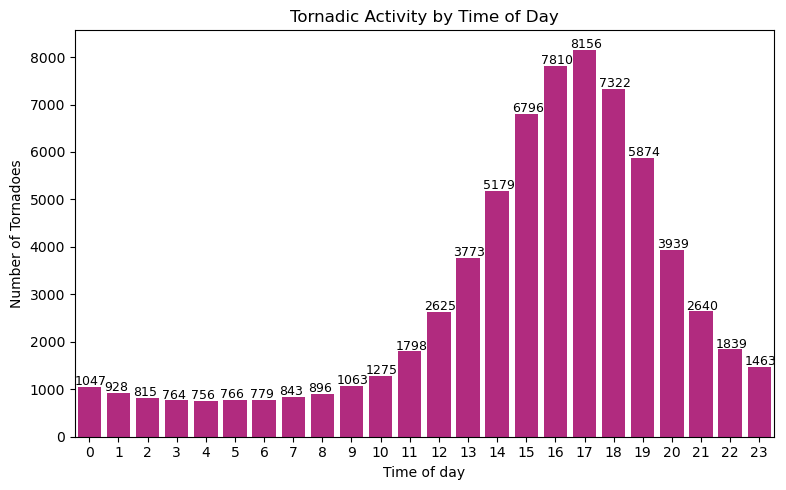

In [15]:
#plot to show the singificant hours of the day that tornados occur in 
plt.figure(figsize=(8,5))
timeOfDay = sns.countplot(x = 'time', data = tornadoUS, color = 'mediumvioletred')
plt.title('Tornadic Activity by Time of Day')
plt.xlabel('Time of day')
plt.ylabel('Number of Tornadoes')
plt.xticks(range(24))
plt.xticks(rotation = 0)
for index, data in enumerate(tornadoUS['time'].value_counts().sort_index(ascending = True)):
    plt.text(x = index -0.5, y = data + 40, s = f"{data}" , fontdict = dict(fontsize=9), rotation = 0)
plt.tight_layout()
plt.show()

The plot shows that tornadoes are more likely to occur between 3pm and 7pm, with the most tornadoes occuring at 5pm. 

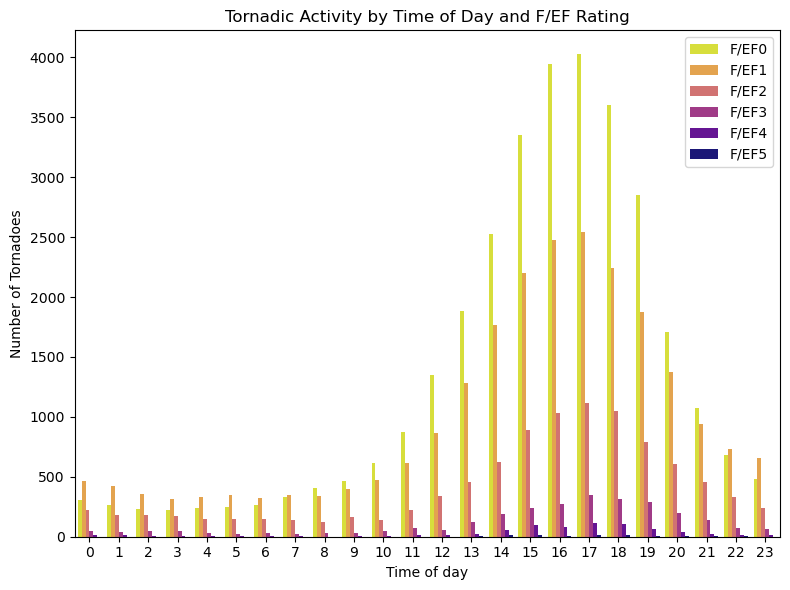

In [17]:
plt.figure(figsize=(8,6))
timeOfDay = sns.countplot(x = 'time', hue = 'rating', data = tornadoUS, palette = "plasma_r")
plt.title('Tornadic Activity by Time of Day and F/EF Rating')
plt.xlabel('Time of day')
plt.ylabel('Number of Tornadoes')
plt.xticks(range(24))
plt.xticks(rotation = 0)
plt.legend(labels = ["F/EF0", "F/EF1", "F/EF2", "F/EF3", "F/EF4", "F/EF5"])
plt.tight_layout()
plt.show()

Shows the significant hours of the day for each EF scale rating. EF5 appears to be smaller at 5pm than at 3pm, so the next visualisation will show the same graph for EF5 tornadoes only. 

In [19]:
tornadoEF5 = tornadoUS[tornadoUS['rating'].isin([5])]

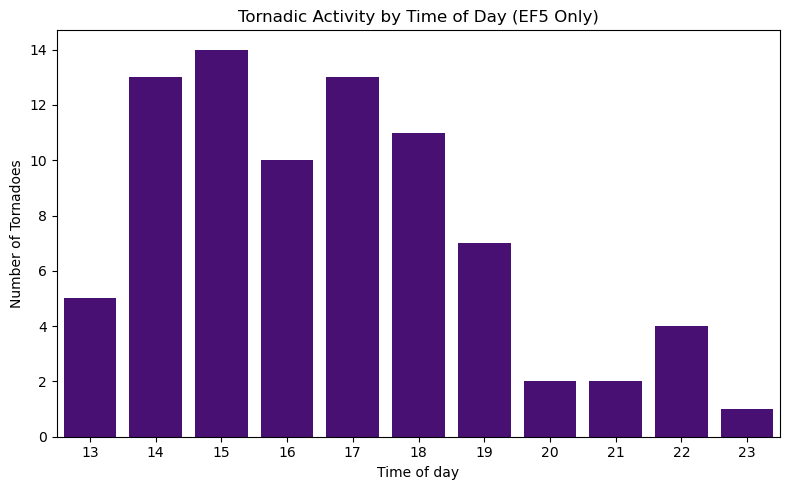

In [20]:
#plot to show the singificant hours of the day that tornados occur in - EF5 tornadoes only
plt.figure(figsize=(8,5))
timeOfDay = sns.countplot(x = 'time', data = tornadoEF5, color = 'indigo')
plt.title('Tornadic Activity by Time of Day (EF5 Only)')
plt.xlabel('Time of day')
plt.ylabel('Number of Tornadoes')

plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

Visualisation shows that 3pm is a signficant time for the occurence of EF5 tornadoes in particular, with 5pm and 4pm being the second most significant times.

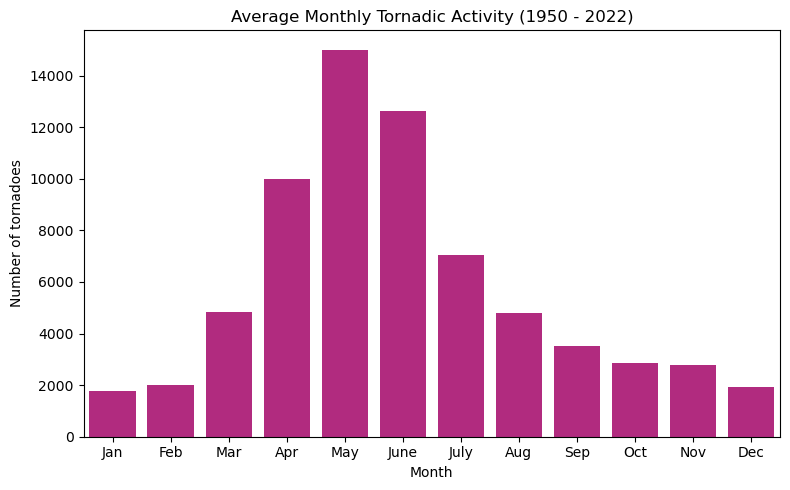

In [22]:
plt.figure(figsize=(8,5))
monthCount = sns.countplot(data = tornadoUS, x = 'mo', color = 'mediumvioletred')
plt.title("Average Monthly Tornadic Activity (1950 - 2022)")
plt.xlabel('Month')
plt.ylabel('Number of tornadoes')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

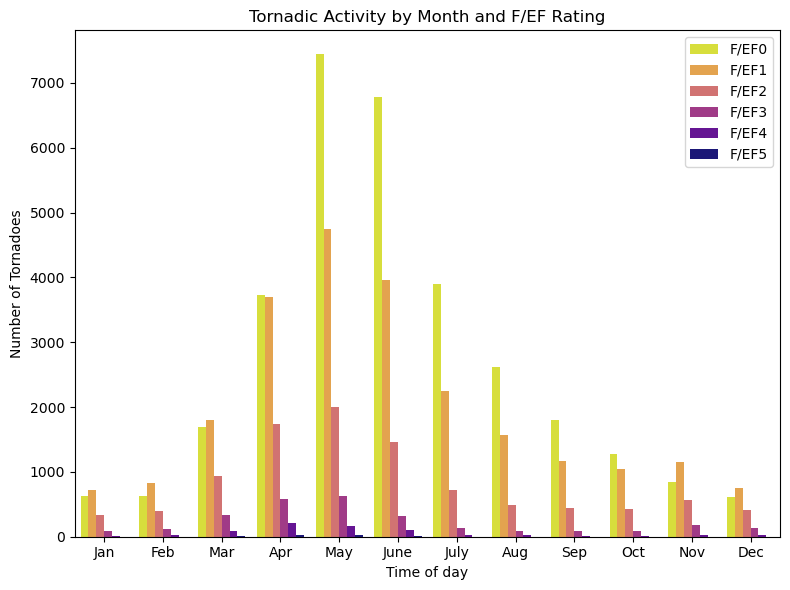

In [23]:
plt.figure(figsize=(8,6))
ratingMonths = sns.countplot(x = 'mo', hue = 'rating', data = tornadoUS, palette = "plasma_r")
plt.title('Tornadic Activity by Month and F/EF Rating')
plt.xlabel('Time of day')
plt.ylabel('Number of Tornadoes')

plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks(rotation = 0)

plt.legend(labels = ["F/EF0", "F/EF1", "F/EF2", "F/EF3", "F/EF4", "F/EF5"])
plt.tight_layout()
plt.show()

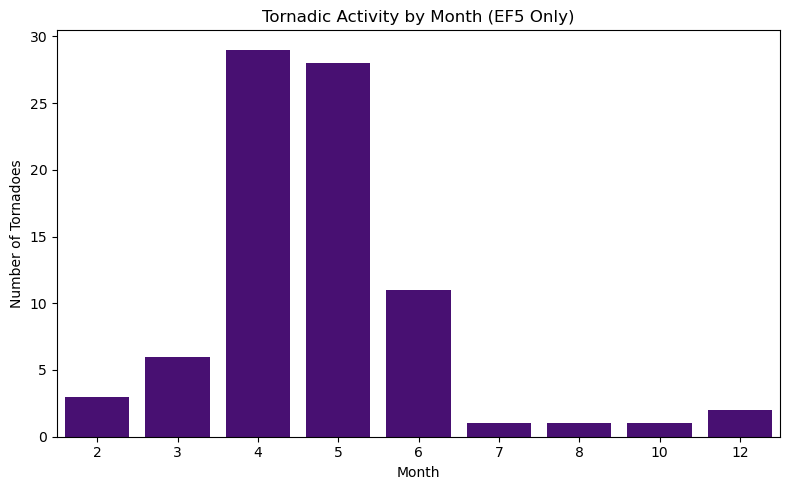

In [24]:
plt.figure(figsize=(8,5))
timeOfDay = sns.countplot(x = 'mo', data = tornadoEF5, color = 'indigo')
plt.title('Tornadic Activity by Month (EF5 Only)')
plt.xlabel('Month')
plt.ylabel('Number of Tornadoes')

plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

In [26]:
yearCounts = tornadoUS['yr'].value_counts().sort_index(ascending = True)
yearCounts

yr
1950     203
1951     260
1952     246
1953     434
1954     566
        ... 
2018    1127
2019    1377
2020    1003
2021    1155
2022    1017
Name: count, Length: 73, dtype: int64

In [27]:
rollingMean = yearCounts.rolling(5).mean()

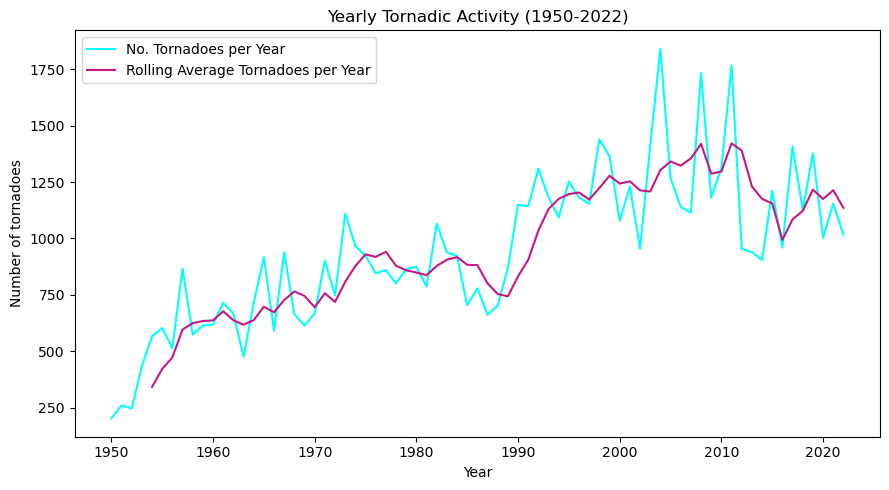

In [28]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.lineplot(yearCounts, color = 'aqua', ax = ax, label = 'No. Tornadoes per Year')
sns.lineplot(rollingMean, color="mediumvioletred", label="Rolling Average Tornadoes per Year")
plt.title('Yearly Tornadic Activity (1950-2022)')
plt.xlabel('Year')
plt.ylabel('Number of tornadoes')
plt.tight_layout()
plt.show()

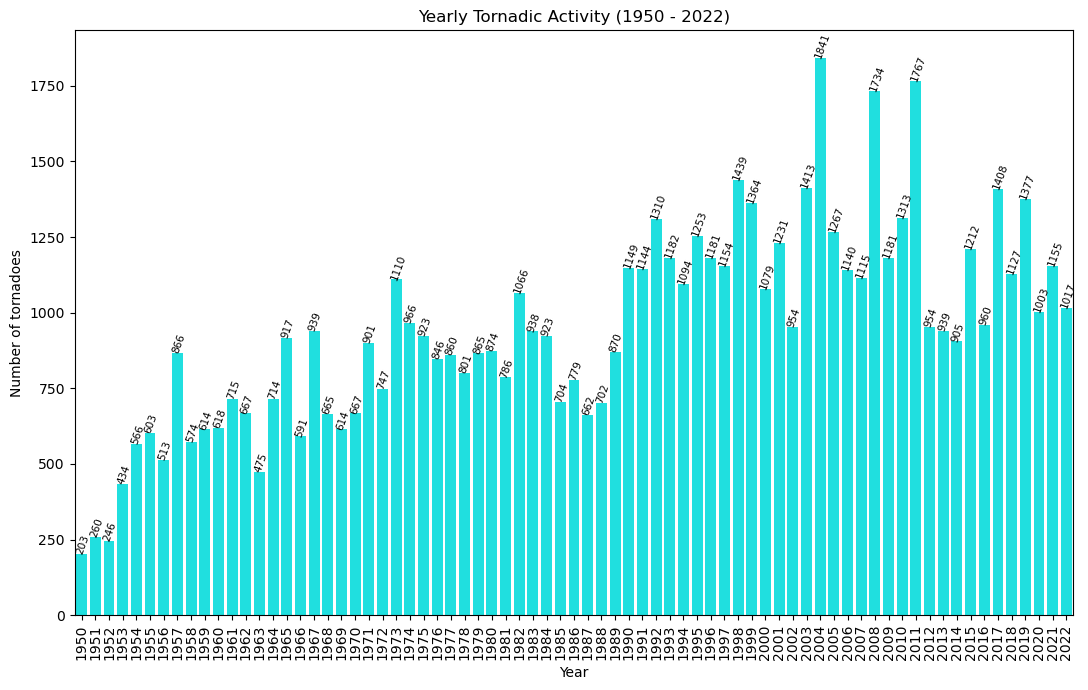

In [81]:
fig, ax = plt.subplots(figsize=(11, 7))
monthCount = sns.countplot(data = tornadoUS, x = 'yr', color = 'aqua', ax = ax)

plt.title("Yearly Tornadic Activity (1950 - 2022)")
plt.xlabel('Year')
plt.ylabel('Number of tornadoes')
plt.xticks(rotation = 90)
for index, data in enumerate(tornadoUS['yr'].value_counts().sort_index(ascending = True)):
    plt.text(x = index -0.5 , y = data + 0.5, s = f"{data}" , fontdict = dict(fontsize=7.5), rotation = 70)

plt.tight_layout()
plt.show()

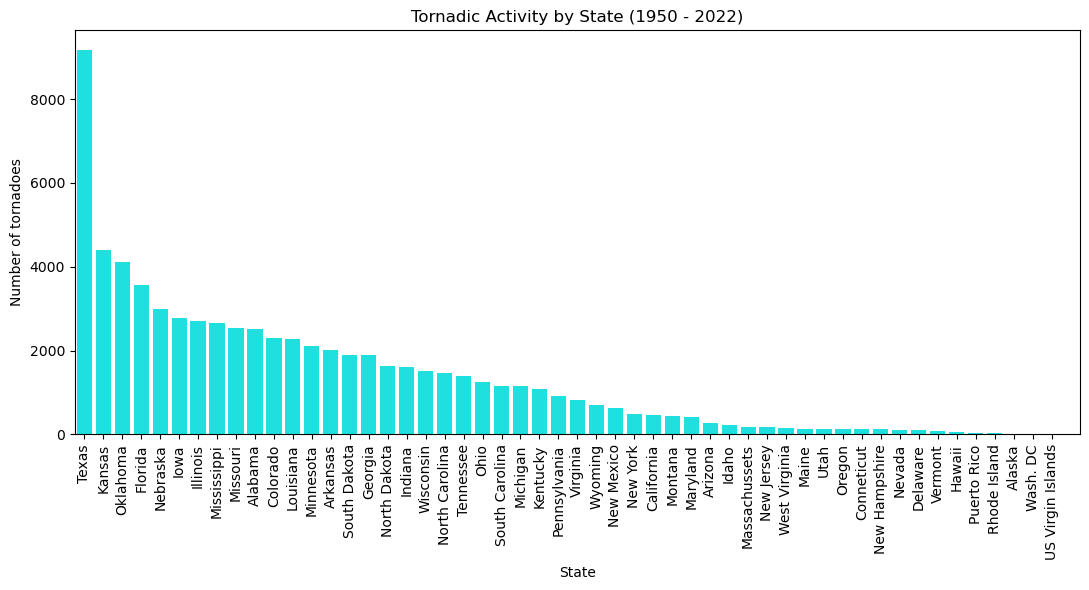

In [83]:
fig, ax = plt.subplots(figsize=(11, 6))
monthCount = sns.countplot(data = tornadoUS, x = 'state', color = 'aqua', ax=ax,  order = tornadoUS['state'].value_counts().index)

plt.title("Tornadic Activity by State (1950 - 2022)")
plt.xlabel('State')
plt.ylabel('Number of tornadoes')
plt.xticks(range(52), ['Texas', 'Kansas', 'Oklahoma', 'Florida', 'Nebraska', 'Iowa', 'Illinois', 'Mississippi', 'Missouri', 'Alabama', 
                      'Colorado', 'Louisiana', 'Minnesota', 'Arkansas', 'South Dakota', 'Georgia', 'North Dakota', 'Indiana', 'Wisconsin', 
                      'North Carolina', 'Tennessee', 'Ohio', 'South Carolina', 'Michigan', 'Kentucky', 'Pennsylvania', 'Virginia', 'Wyoming', 
                      'New Mexico', 'New York', 'California', 'Montana', 'Maryland', 'Arizona', 'Idaho', 'Massachussets', 'New Jersey', 'West Virginia',
                      'Maine', 'Utah', 'Oregon', 'Conneticut', 'New Hampshire', 'Nevada', 'Delaware', 'Vermont', 'Hawaii', 'Puerto Rico', 'Rhode Island',
                      'Alaska', 'Wash. DC', 'US Virgin Islands'])

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

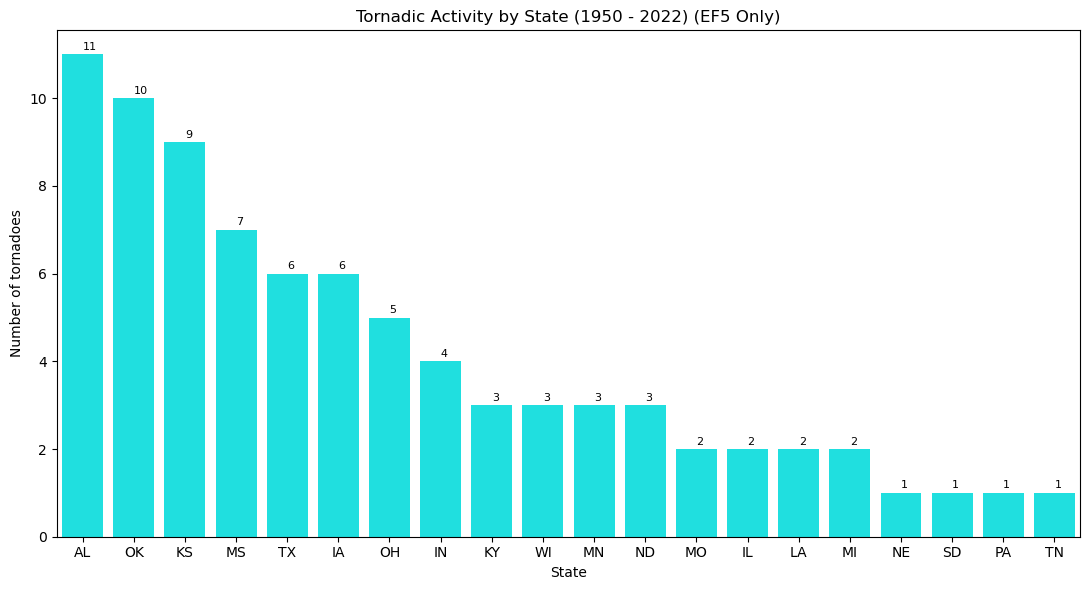

In [77]:
fig, ax = plt.subplots(figsize=(11, 6))
monthCountF5 = sns.countplot(data = tornadoEF5, x = 'state', color = 'aqua', ax=ax,  order = tornadoEF5['state'].value_counts().index)

plt.title("Tornadic Activity by State (1950 - 2022) (EF5 Only)")
plt.xlabel('State')
plt.ylabel('Number of tornadoes')

for index, data in enumerate(tornadoEF5['state'].value_counts()):
    plt.text(x = index, y = data + 0.1, s = f"{data}", fontdict = dict(fontsize=8))

plt.tight_layout()
plt.show()

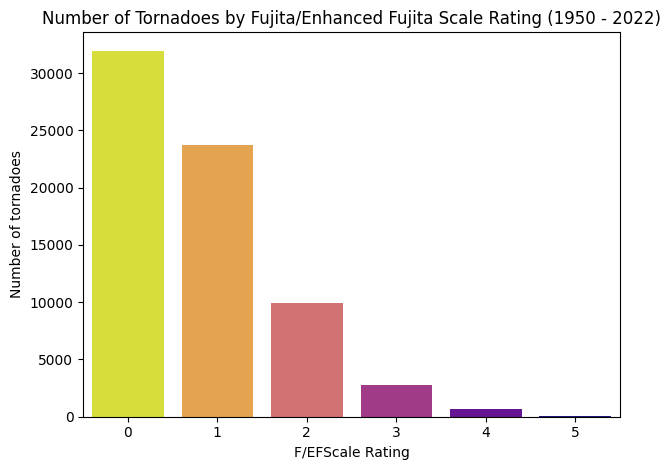

In [26]:
fefCount = sns.countplot(data = tornadoUS, x = 'rating', hue = 'rating', palette = 'plasma_r' , legend = False)
plt.title("Number of Tornadoes by Fujita/Enhanced Fujita Scale Rating (1950 - 2022)")
plt.xlabel('F/EFScale Rating')
plt.ylabel('Number of tornadoes')
plt.xticks(range(6), ['0', '1', '2', '3', '4', '5'])
plt.tight_layout()
plt.show()

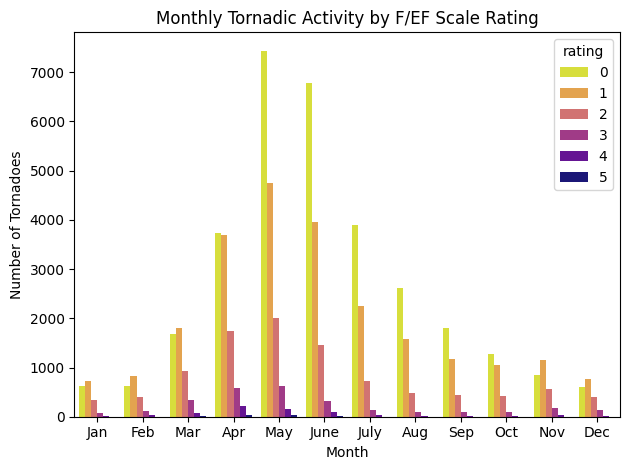

In [27]:
dayOfWeek = sns.countplot(x = 'mo', hue = 'rating', data = tornadoUS, palette = "plasma_r")
plt.title('Monthly Tornadic Activity by F/EF Scale Rating')
plt.xlabel('Month')
plt.ylabel('Number of Tornadoes')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

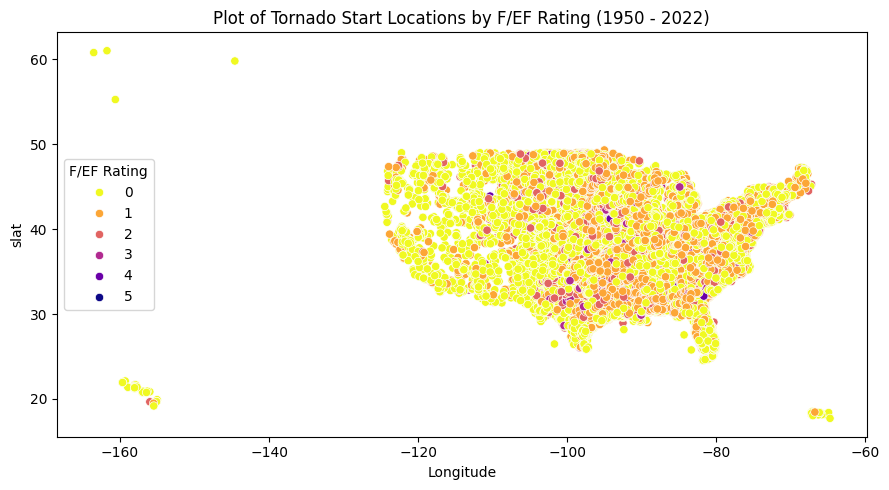

In [28]:
fig, ax = plt.subplots(figsize=(9, 5))
tornadoLoc = sns.scatterplot(data = tornadoUS,  x = 'slon', y = 'slat', hue = 'rating', palette = 'plasma_r', ax = ax)
handles, labels  =  tornadoLoc.get_legend_handles_labels()
tornadoLoc.set_title('Plot of Tornado Start Locations by F/EF Rating (1950 - 2022)')
tornadoLoc.set_xlabel('Longitude')
tornadoLoc.set_xlabel('Longitude')
tornadoLoc.legend(handles, ['0', '1', '2', '3', '4', '5'], loc='center left')
tornadoLoc.legend(title = 'F/EF Rating')

plt.tight_layout()
plt.show()

In [85]:
f5DF = tornadoUS[(tornadoUS['rating'] == 5)]

In [87]:
f5DF.sort_values(by = 'fatalities', ascending = False)

,yr,mo,dy,date,time,tz,state,rating,injuries,fatalities,property_loss,crop_loss,slat,slon,elat,elon,len,wid,no_states
56582,2011,5,22,2011-05-22,16,3,MO,5,1150,158,2800.1,0.0,37.0524,-94.5932,36.9838,-94.2213,21.62,1600,1
1087,1953,6,8,1953-06-08,19,3,MI,5,844,116,7.0,0.0,43.1000,-83.8500,43.1700,-83.4200,18.90,833,1
911,1953,5,11,1953-05-11,16,3,TX,5,597,114,7.0,0.0,31.5500,-97.1500,31.7500,-96.8800,20.90,583,1
1991,1955,5,25,1955-05-25,22,3,OK,5,273,80,5.0,0.0,36.8800,-97.1500,37.4500,-96.7500,56.40,1320,2
1993,1955,5,25,1955-05-25,22,3,KS,5,273,80,5.0,0.0,37.0000,-97.2500,37.4500,-96.7500,48.40,1320,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22529,1982,4,2,1982-04-02,15,3,OK,5,29,0,6.0,0.0,34.1300,-95.5700,34.0000,-94.5700,53.00,500,1
15584,1974,4,3,1974-04-03,15,3,KY,5,20,0,6.0,0.0,38.9800,-84.8700,39.1200,-84.6700,14.00,533,3
17748,1976,6,13,1976-06-13,14,3,IA,5,9,0,7.0,0.0,41.9300,-93.8700,42.1800,-93.6000,21.30,880,1
17483,1976,4,19,1976-04-19,17,3,TX,5,11,0,6.0,0.0,31.7200,-99.0700,31.8200,-98.9300,10.50,440,1


In [89]:
coordsList = [tornadoUS['slat'].mean(), tornadoUS['slon'].mean()]
f5Map = folium.Map(location=(coordsList[0], coordsList[1]), zoom_start=5)

#iterating through the start latitude and longitude columns within f5DF and getting the values of each  
#getting the date, injuries, and fatalities info for each to display in popups 
for index, row in f5DF.iterrows():
    coordinates = [row['slat'], row['slon']]
    date = row['date']
    fatalities = row['fatalities']
    injuries = row['injuries']
    damage = row['property_loss']

    f5Map.add_child(folium.Marker(location = coordinates, popup = [date, f"Property Damage: {damage}", f"Injuries: {injuries}",
                                    f"Fatalities: {fatalities}"], icon = folium.Icon(color = 'darkpurple', icon = "flash")))

f5Map

In [32]:
fatalities = tornadoUS.groupby('rating')['fatalities'].mean()
fatalities

rating
0     0.000782
1     0.010383
2     0.066331
3     0.558114
4     4.189341
5    21.792683
Name: fatalities, dtype: float64

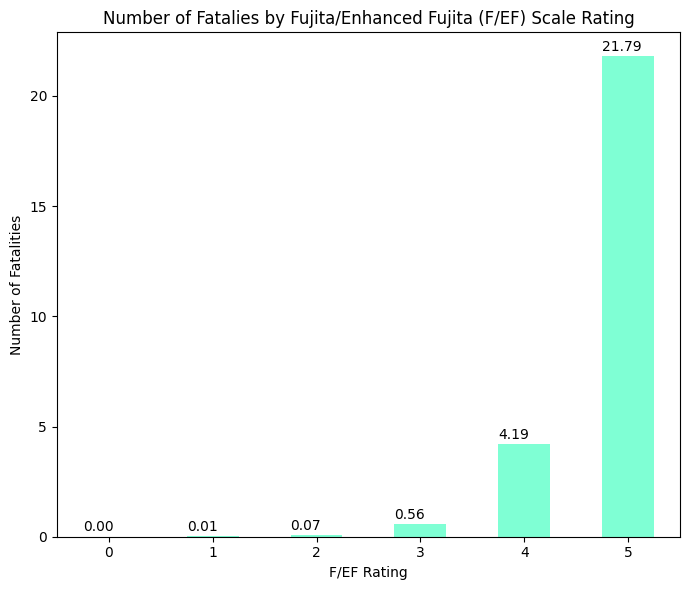

In [33]:
#plotting mean fatalities for each rating
plt.figure(figsize=(7,6))
fatalities.plot(kind = 'bar', color = 'aquamarine')
plt.title('Number of Fatalies by Fujita/Enhanced Fujita (F/EF) Scale Rating')
plt.xlabel('F/EF Rating')
plt.ylabel('Number of Fatalities')
for index, data in enumerate(fatalities):
    plt.text(x = index -0.25, y = data +0.25, s = f"{data:.2f}" , fontdict = dict(fontsize=10))
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

In [34]:
injuries = tornadoUS.groupby('rating')['injuries'].mean()
injuries

rating
0      0.027160
1      0.308868
2      1.704435
3      9.872256
4     60.176718
5    195.231707
Name: injuries, dtype: float64

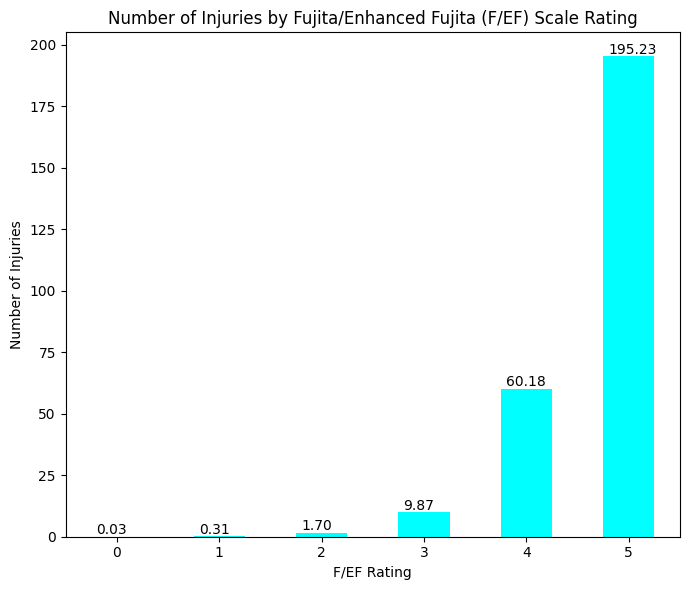

In [35]:
#plotting mean fatalities for each rating
plt.figure(figsize=(7,6))
injuries.plot(kind = 'bar', color = 'cyan')
plt.title('Number of Injuries by Fujita/Enhanced Fujita (F/EF) Scale Rating')
plt.xlabel('F/EF Rating')
plt.ylabel('Number of Injuries')
for index,data in enumerate(injuries):
    plt.text(x = index -0.2, y = data + 1 , s = f"{data:.2f}" , fontdict = dict(fontsize = 10))
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

## Comparison in Activity (1950-52 vs 2020-22)

In [93]:
tornado50 = tornadoUS[tornadoUS['yr'].isin([1950, 1951, 1952])]

In [95]:
tornado50

,yr,mo,dy,date,time,tz,state,rating,injuries,fatalities,property_loss,crop_loss,slat,slon,elat,elon,len,wid,no_states
0,1950,10,1,1950-10-01,21,3,OK,1,0,0,4.0,0.0,36.73,-102.52,36.88,-102.30,15.8,10,1
1,1950,10,9,1950-10-09,2,3,NC,3,3,0,5.0,0.0,34.17,-78.60,0.00,0.00,2.0,880,1
2,1950,11,20,1950-11-20,2,3,KY,2,0,0,5.0,0.0,37.37,-87.20,0.00,0.00,0.1,10,1
3,1950,11,20,1950-11-20,4,3,KY,1,0,0,5.0,0.0,38.20,-84.50,0.00,0.00,0.1,10,1
4,1950,11,20,1950-11-20,7,3,MS,1,3,0,4.0,0.0,32.42,-89.13,0.00,0.00,2.0,37,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,1952,8,31,1952-08-31,22,3,MD,1,0,0,4.0,0.0,39.02,-77.22,39.03,-77.23,0.1,70,1
709,1952,8,3,1952-08-03,15,3,MS,2,0,0,4.0,0.0,34.37,-89.52,0.00,0.00,0.3,200,1
710,1952,8,7,1952-08-07,18,3,KS,3,0,0,0.0,0.0,39.00,-98.52,39.05,-98.45,4.7,10,1
711,1952,8,7,1952-08-07,22,3,KS,1,0,0,0.0,0.0,37.93,-99.42,0.00,0.00,0.1,10,1


In [97]:
tornado20 = tornadoUS[tornadoUS['yr'].isin([2020, 2021, 2022])]

In [99]:
tornado20

,yr,mo,dy,date,time,tz,state,rating,injuries,fatalities,property_loss,crop_loss,slat,slon,elat,elon,len,wid,no_states
66390,2020,10,10,2020-10-10,4,3,AL,0,0,0,0.0,0.0,30.4803,-88.2508,30.4814,-88.2505,0.08,25,1
66391,2020,10,10,2020-10-10,5,3,WA,1,0,0,0.0,0.0,47.3688,-123.9473,47.3715,-123.9383,0.50,30,1
66392,2020,10,10,2020-10-10,14,3,GA,1,0,0,250000.0,0.0,33.5870,-83.8770,33.6070,-83.8840,1.44,75,1
66393,2020,10,10,2020-10-10,15,3,AL,0,0,0,0.0,0.0,32.9462,-85.3531,32.9557,-85.3515,0.67,125,1
66394,2020,10,10,2020-10-10,16,3,GA,0,0,0,100000.0,0.0,33.3650,-84.8110,33.3700,-84.8110,0.35,90,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70031,2022,9,28,2022-09-28,3,3,FL,0,0,0,2000.0,0.0,26.5282,-80.0680,26.5282,-80.0680,0.20,50,1
70032,2022,9,28,2022-09-28,13,3,FL,0,0,0,0.0,0.0,28.0830,-80.8669,28.1249,-80.8841,3.00,100,1
70033,2022,9,30,2022-09-30,10,3,NC,0,0,0,0.0,0.0,33.9128,-78.2882,33.9132,-78.3011,0.74,20,1
70035,2022,9,4,2022-09-04,15,3,OH,0,0,0,12000.0,0.0,41.0210,-80.6559,41.0220,-80.6555,0.07,15,1


C:\Users\leahj\AppData\Local\Temp\ipykernel_18000\3582984238.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=tornado50, x='yr', palette = 'plasma')
C:\Users\leahj\AppData\Local\Temp\ipykernel_18000\3582984238.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=tornado20, x='yr', palette = 'plasma')


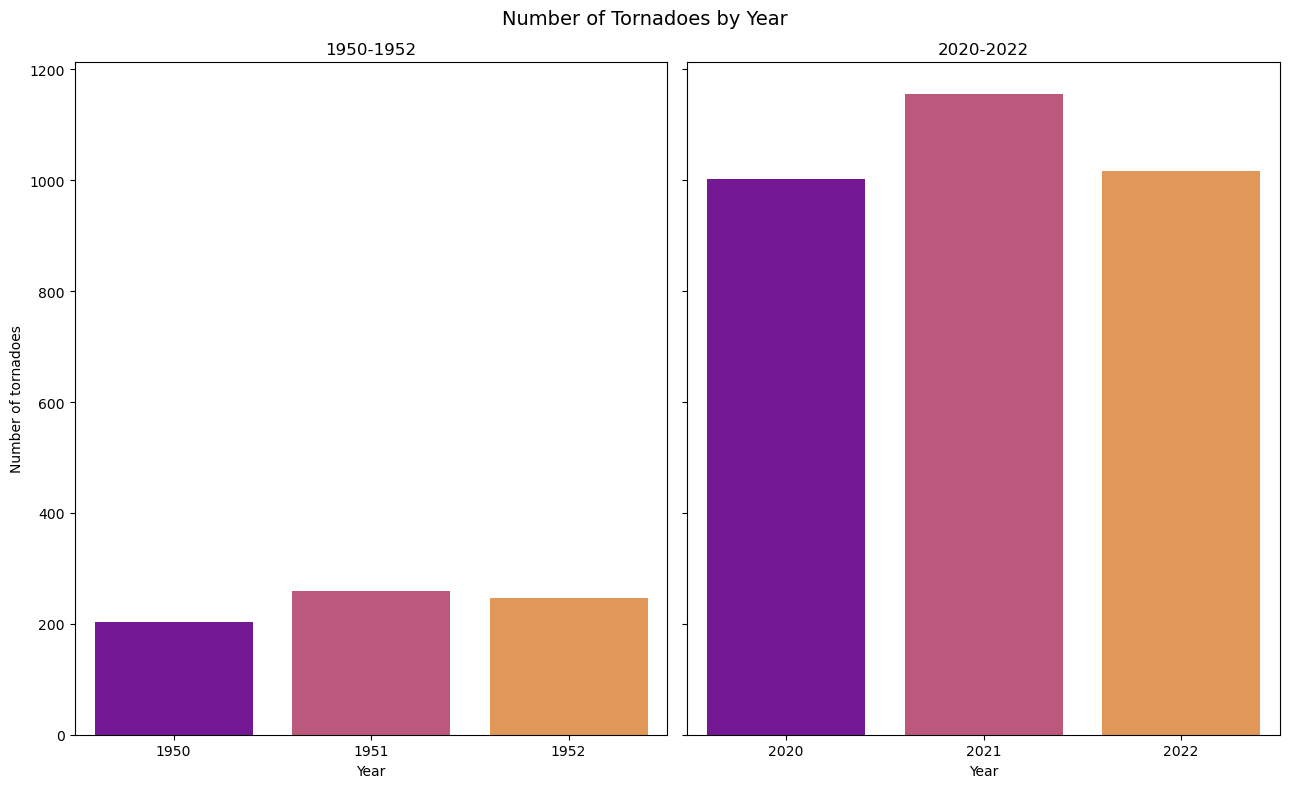

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(13, 8), sharey = True)  # 1 row, 2 columns

fig.suptitle('Number of Tornadoes by Year', fontsize = 14)


sns.countplot(ax=axes[0], data=tornado50, x='yr', palette = 'plasma')
axes[0].set_title('1950-1952')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of tornadoes')


sns.countplot(ax=axes[1], data=tornado20, x='yr', palette = 'plasma')
axes[1].set_title('2020-2022')
axes[1].set_xlabel('Year')

# Show the plot
plt.tight_layout()
plt.show()

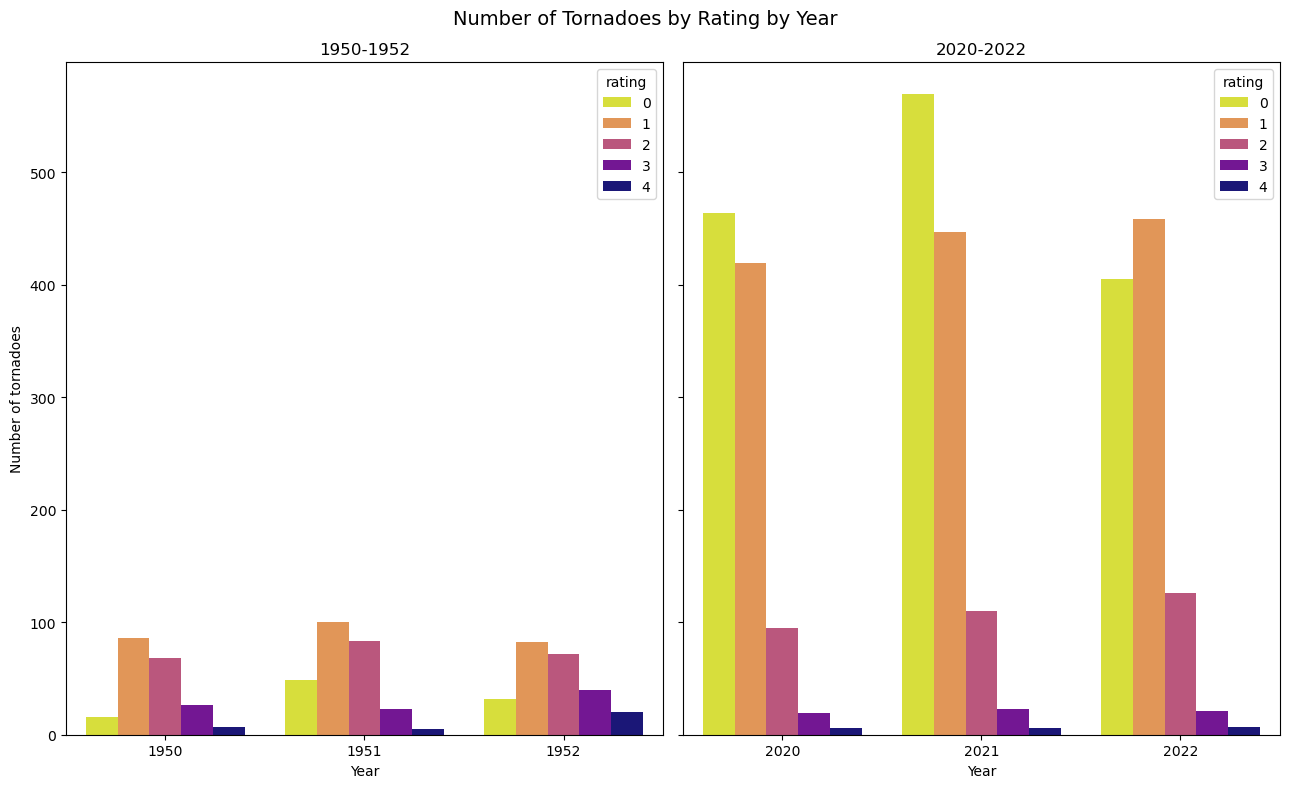

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(13, 8), sharey = True)  # 1 row, 2 columns

fig.suptitle('Number of Tornadoes by Rating by Year', fontsize = 14)


sns.countplot(ax=axes[0], data=tornado50, x='yr', hue = 'rating', palette = 'plasma_r')
axes[0].set_title('1950-1952')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of tornadoes')


sns.countplot(ax=axes[1], data=tornado20, x='yr', hue = 'rating', palette = 'plasma_r')
axes[1].set_title('2020-2022')
axes[1].set_xlabel('Year')

# Show the plot
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

C:\Users\leahj\AppData\Local\Temp\ipykernel_18000\1694117467.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=tornado50, x='mo', palette = 'plasma_r')
C:\Users\leahj\AppData\Local\Temp\ipykernel_18000\1694117467.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=tornado20, x='mo', palette = 'plasma_r')


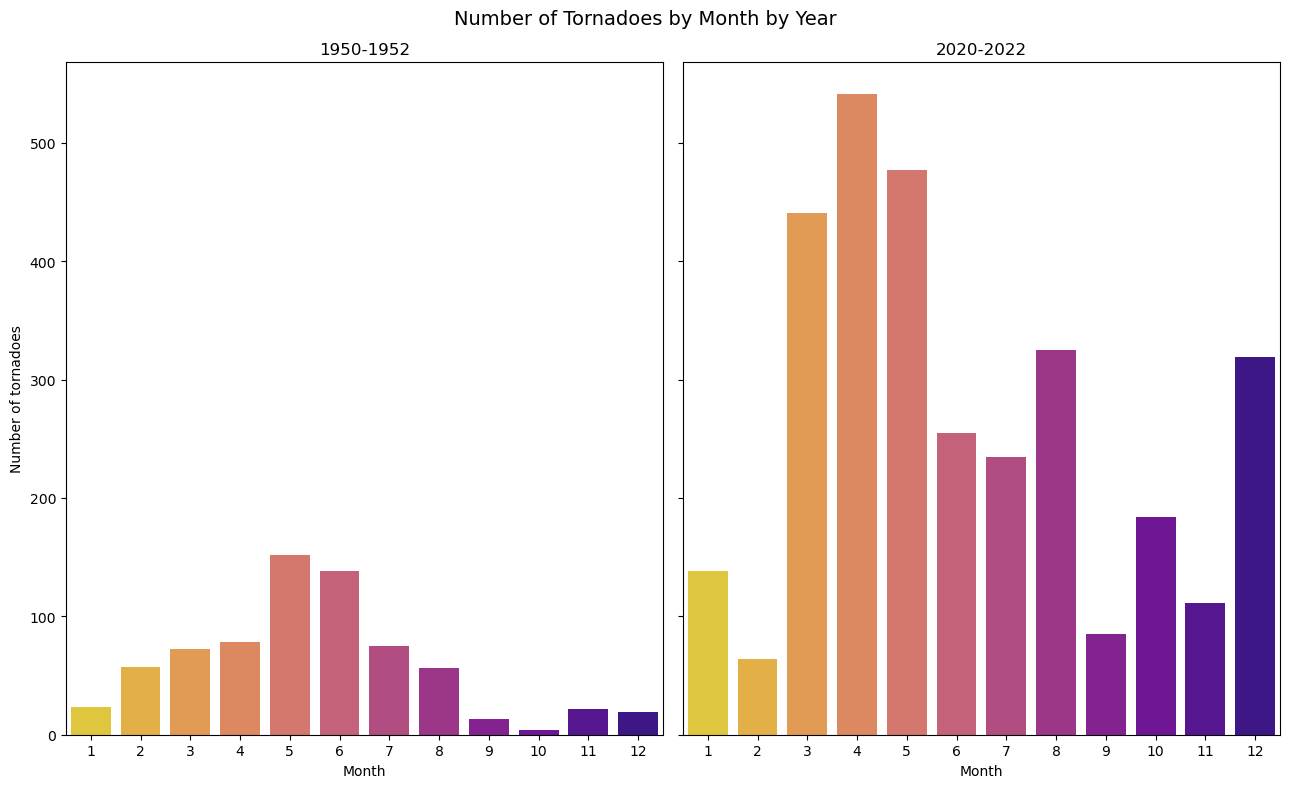

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(13, 8), sharey = True)  # 1 row, 2 columns

fig.suptitle('Number of Tornadoes by Month by Year', fontsize = 14)


sns.countplot(ax=axes[0], data=tornado50, x='mo', palette = 'plasma_r')
axes[0].set_title('1950-1952')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of tornadoes')


sns.countplot(ax=axes[1], data=tornado20, x='mo', palette = 'plasma_r')
axes[1].set_title('2020-2022')
axes[1].set_xlabel('Month')

# Show the plot
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

C:\Users\leahj\AppData\Local\Temp\ipykernel_18000\3351116011.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=tornado50, x='state', palette = 'plasma_r', order = tornado50['state'].value_counts().index)
C:\Users\leahj\AppData\Local\Temp\ipykernel_18000\3351116011.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=tornado20, x='state', palette = 'plasma_r', order = tornado20['state'].value_counts().index)
C:\Users\leahj\AppData\Local\Temp\ipykernel_18000\3351116011.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation

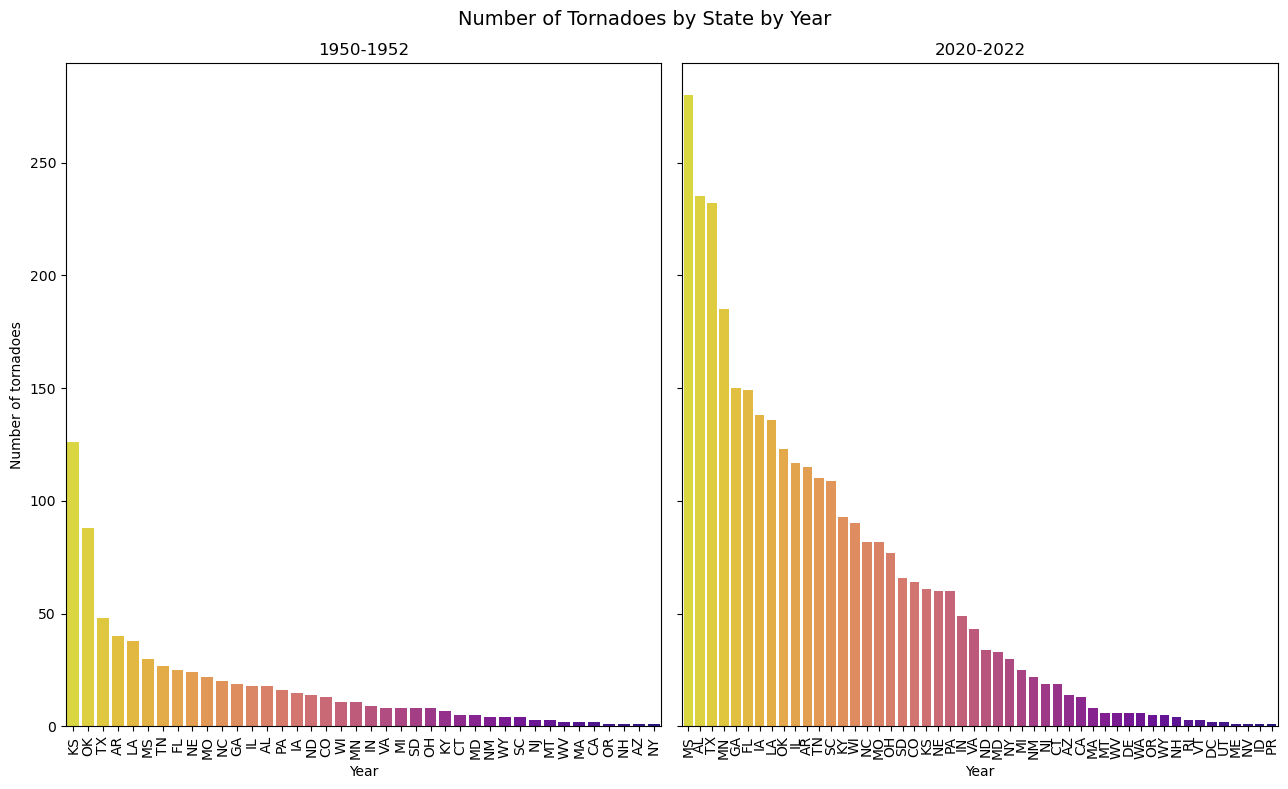

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(13, 8), sharey = True)  # 1 row, 2 columns

fig.suptitle('Number of Tornadoes by State by Year', fontsize = 14)


sns.countplot(ax=axes[0], data=tornado50, x='state', palette = 'plasma_r', order = tornado50['state'].value_counts().index)
axes[0].set_title('1950-1952')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of tornadoes')


sns.countplot(ax=axes[1], data=tornado20, x='state', palette = 'plasma_r', order = tornado20['state'].value_counts().index)
axes[1].set_title('2020-2022')
axes[1].set_xlabel('Year')

# Show the plot
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

In [109]:
fatal50 = tornado50.groupby('yr')['fatalities'].sum()
fatal50

yr
1950     70
1951     34
1952    247
Name: fatalities, dtype: int64

In [111]:
fatal20 = tornado20.groupby('yr')['fatalities'].sum()
fatal20

yr
2020     78
2021    169
2022     24
Name: fatalities, dtype: int64

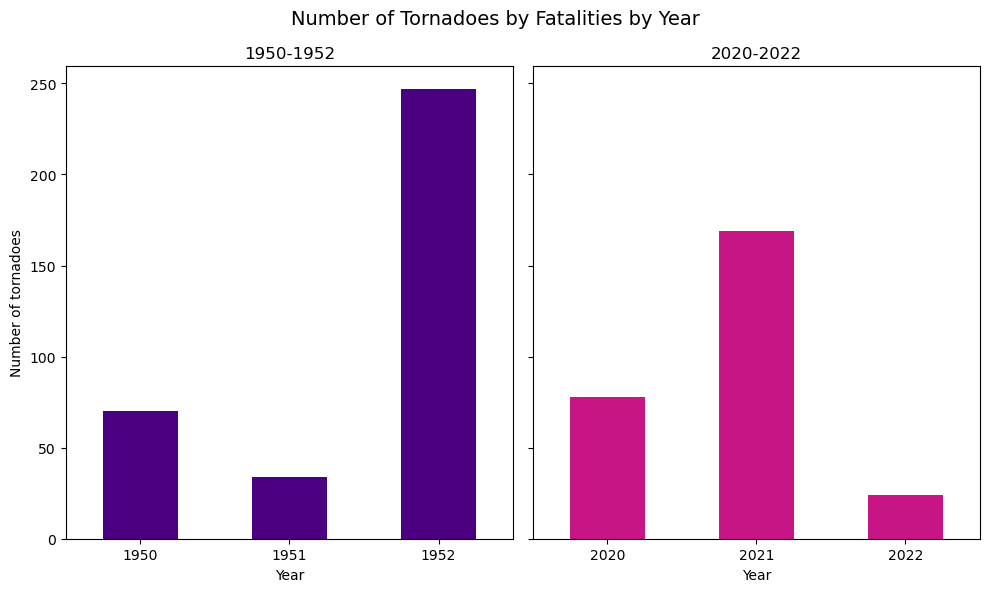

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey = True)  # 1 row, 2 columns

fig.suptitle('Number of Tornadoes by Fatalities by Year', fontsize = 14)


fatal50.plot(ax=axes[0], kind = 'bar', color = 'indigo')
axes[0].set_title('1950-1952')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of tornadoes')


fatal20.plot(ax=axes[1], kind = 'bar', color = 'mediumvioletred')
axes[1].set_title('2020-2022')
axes[1].set_xlabel('Year')

# Show the plot
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## Classification Models

### Features, SMOTE, Split

In [33]:
features = ['mo','time', 'fatalities', 'injuries', 'len', 'wid', 'property_loss', 'crop_loss', 'no_states']
xForest = tornadoUS[features]
yForest = tornadoUS['rating']
xForest

,mo,time,fatalities,injuries,len,wid,property_loss,crop_loss,no_states
0,10,21,0,0,15.80,10,4.0,0.0,1
1,10,2,0,3,2.00,880,5.0,0.0,1
2,11,2,0,0,0.10,10,5.0,0.0,1
3,11,4,0,0,0.10,10,5.0,0.0,1
4,11,7,0,3,2.00,37,4.0,0.0,1
...,...,...,...,...,...,...,...,...,...
70031,9,3,0,0,0.20,50,2000.0,0.0,1
70032,9,13,0,0,3.00,100,0.0,0.0,1
70033,9,10,0,0,0.74,20,0.0,0.0,1
70035,9,15,0,0,0.07,15,12000.0,0.0,1


In [34]:
#label encoding the month column so that it can be used as a feature
#chose label encoding as it implies that the numbers have a meaningful order 
# - useful here as some months (Apr - June) have much more activity than others
label_encoder = LabelEncoder()
xForest['mo'] = label_encoder.fit_transform(xForest['mo'])
xForest['time'] = label_encoder.fit_transform(xForest['time'])
xForest

C:\Users\leahj\AppData\Local\Temp\ipykernel_8964\4156758977.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xForest['mo'] = label_encoder.fit_transform(xForest['mo'])
C:\Users\leahj\AppData\Local\Temp\ipykernel_8964\4156758977.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xForest['time'] = label_encoder.fit_transform(xForest['time'])


,mo,time,fatalities,injuries,len,wid,property_loss,crop_loss,no_states
0,9,21,0,0,15.80,10,4.0,0.0,1
1,9,2,0,3,2.00,880,5.0,0.0,1
2,10,2,0,0,0.10,10,5.0,0.0,1
3,10,4,0,0,0.10,10,5.0,0.0,1
4,10,7,0,3,2.00,37,4.0,0.0,1
...,...,...,...,...,...,...,...,...,...
70031,8,3,0,0,0.20,50,2000.0,0.0,1
70032,8,13,0,0,3.00,100,0.0,0.0,1
70033,8,10,0,0,0.74,20,0.0,0.0,1
70035,8,15,0,0,0.07,15,12000.0,0.0,1


In [35]:
counter = Counter(yForest)
print(counter)

Counter({0: 31959, 1: 23693, 2: 9920, 3: 2779, 4: 713, 5: 82})


In [113]:
over = SMOTE(sampling_strategy={1:26000, 2:22000, 3:18000, 4:14000, 5:10000})
under = RandomUnderSampler(sampling_strategy={0:30000})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

xForestSMOTE, yForestSMOTE = pipeline.fit_resample(xForest, yForest)

In [114]:
counter = Counter(yForestSMOTE)
print(counter)

Counter({0: 30000, 1: 26000, 2: 22000, 3: 18000, 4: 14000, 5: 10000})


In [115]:
xTrain, xTest, yTrain, yTest = train_test_split(xForestSMOTE, yForestSMOTE, test_size = 0.3, random_state = 42)

### Random Forest

In [101]:
parameters = {'n_estimators': [100,200,400],
              'max_depth':[None, 10,20,40],
              'min_samples_split': [2,5,10],
              'min_samples_leaf':[1,2,4], 
              'bootstrap':[True, False]
}

In [102]:
randAlFor = RandomForestClassifier(random_state = 42)

In [103]:
#creating the gridsearch model
gridSearch = GridSearchCV(estimator=randAlFor, param_grid=parameters, cv=5, scoring='accuracy', n_jobs=-1)
#fitting the gridsearch model to the training data 
gridSearch.fit(xTrain, yTrain)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 400]},
             scoring='accuracy')

laptop time taken (with states): 3871 seconds
without: 2986

In [104]:
#getting the best parameters and best cross-validation score of the models tested within the gridsearch
bestParams = gridSearch.best_params_
bestScore = gridSearch.best_score_

#printing the best parameters and best score 
print(f"Best parameters: {bestParams}")
print(f"Best cross-validation score: {bestScore}")

Best parameters: {'bootstrap': False, 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
Best cross-validation score: 0.7465714285714287


In [105]:
#assigning the best performing model to a variable to be used for predictions 
bestEst = gridSearch.best_estimator_

#making predictions using the best performing estimator 
yPred = bestEst.predict(xTest)
yPred

array([2, 0, 0, ..., 3, 2, 4], dtype=int64)

In [106]:
accuracyRF = accuracy_score(yTest, yPred)
print(f"Accuracy:{accuracyRF:.2f}")

Accuracy:0.76


#### Classification Report and Heatmap

In [107]:
print("Classification Report: \n", classification_report(yTest, yPred, zero_division=1))

Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.77      0.76      8970
           1       0.60      0.61      0.61      9106
           2       0.68      0.65      0.67      7516
           3       0.84      0.83      0.83      6015
           4       0.94      0.95      0.95      4415
           5       0.99      1.00      1.00      2978

    accuracy                           0.76     39000
   macro avg       0.80      0.80      0.80     39000
weighted avg       0.76      0.76      0.76     39000



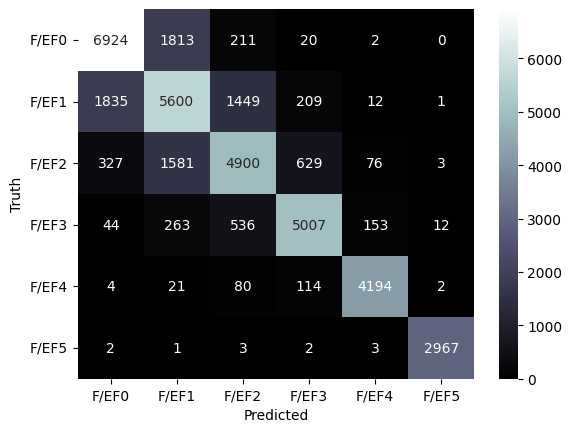

In [108]:
#generating the confusion matrix
cm = confusion_matrix(yTest, yPred)

#making a list of the labels that will be used on the heatmap - more understandable than 0,1,2
labels = ["F/EF0", "F/EF1", "F/EF2", "F/EF3", "F/EF4", "F/EF5"]

#defining the heatmap using seaborn
cmVis = sns.heatmap(cm, annot=True, fmt='d', cmap ='bone')

#setting the x and y labels of the heatmap to the labels in the list 
cmVis.set_xticklabels(labels, rotation=0)
cmVis.set_yticklabels(labels, rotation=0)

#setting the x and y axis labels
plt.xlabel('Predicted')
plt.ylabel('Truth')	

#displaying the graph
plt.show()

#### Feature Importance

In [109]:
#creating a pandas series containing the importance of each of the features used within the model
#ascending = false so that the features with the highest importance are shown first
featureImport = pd.Series(bestEst.feature_importances_, index=xForest.columns).sort_values(ascending = False)

C:\Users\leahj\AppData\Local\Temp\ipykernel_19664\545062923.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = featureImport, y = featureImport.index, palette = 'plasma')


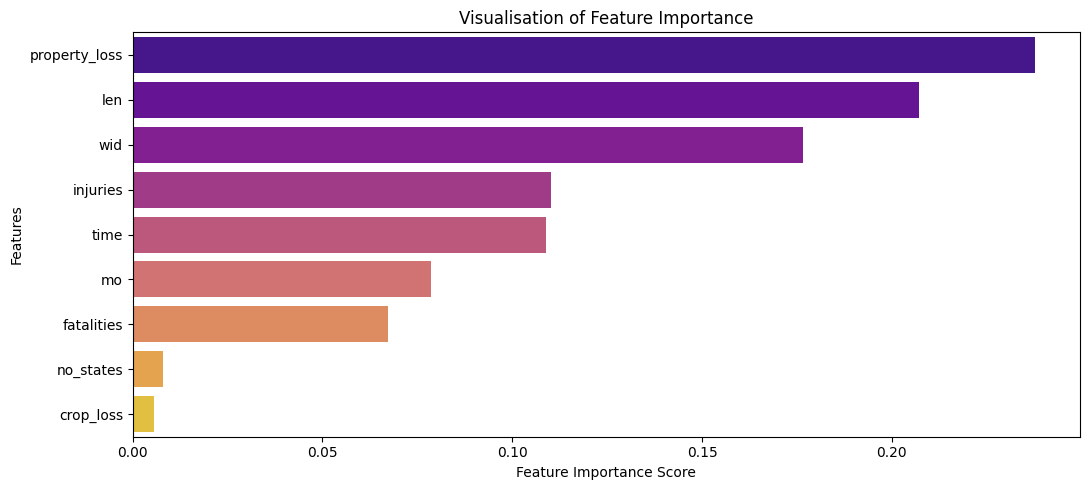

In [110]:
#plotting the feature importance using the pandas series 
plt.figure(figsize=(11,5))

#uses .index to get the names of the features
sns.barplot(x = featureImport, y = featureImport.index, palette = 'plasma')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualisation of Feature Importance")

plt.tight_layout()
plt.show()

### Deep Learning

In [116]:
early_stopping2 = EarlyStopping(monitor='loss', patience = 10)
reduce_lr2 = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=4, min_lr=0.001)

In [139]:
annModel = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_dim = xTrain.shape[1], activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(6, activation='softmax')    
])

In [140]:
annModel.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(0.01), metrics=['accuracy'])

In [141]:
annModel.fit(xTrain, yTrain, epochs = 100, batch_size=64, verbose=2, callbacks = [early_stopping2, reduce_lr2])

Epoch 1/100
1313/1313 - 4s - 3ms/step - accuracy: 0.4578 - loss: 293.4949 - learning_rate: 0.0100
Epoch 2/100
1313/1313 - 1s - 1ms/step - accuracy: 0.5205 - loss: 1.1223 - learning_rate: 0.0100
Epoch 3/100
1313/1313 - 2s - 1ms/step - accuracy: 0.5237 - loss: 1.1271 - learning_rate: 0.0100
Epoch 4/100
1313/1313 - 2s - 1ms/step - accuracy: 0.5272 - loss: 1.0904 - learning_rate: 0.0100
Epoch 5/100
1313/1313 - 2s - 1ms/step - accuracy: 0.5289 - loss: 1.0807 - learning_rate: 0.0100
Epoch 6/100
1313/1313 - 2s - 1ms/step - accuracy: 0.5323 - loss: 1.0741 - learning_rate: 0.0100
Epoch 7/100
1313/1313 - 2s - 1ms/step - accuracy: 0.5262 - loss: 1.1715 - learning_rate: 0.0100
Epoch 8/100
1313/1313 - 2s - 1ms/step - accuracy: 0.5318 - loss: 1.0822 - learning_rate: 0.0100
Epoch 9/100
1313/1313 - 2s - 1ms/step - accuracy: 0.5321 - loss: 1.0793 - learning_rate: 0.0100
Epoch 10/100
1313/1313 - 2s - 1ms/step - accuracy: 0.5306 - loss: 1.0801 - learning_rate: 0.0100


In [142]:
yPredANN = annModel.predict(xTest)
yPredClasses = np.argmax(yPredANN, axis=1)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step


In [143]:
accuracyANN = accuracy_score(yTest, yPredClasses)
print(f"Accuracy:{accuracyANN:.2f}")

Accuracy:0.54


In [144]:
print("Classification Report: \n", classification_report(yTest, yPredClasses, zero_division=1))

Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.70      0.73      8990
           1       0.44      0.61      0.51      7915
           2       0.40      0.40      0.40      6658
           3       0.43      0.25      0.32      5403
           4       0.50      0.47      0.48      4092
           5       0.73      0.75      0.74      2942

    accuracy                           0.54     36000
   macro avg       0.54      0.53      0.53     36000
weighted avg       0.54      0.54      0.53     36000



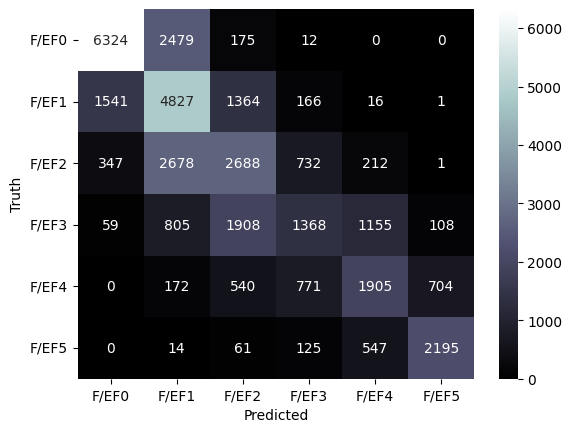

In [145]:
#generating the confusion matrix
cm2 = confusion_matrix(yTest, yPredClasses)

#making a list of the labels that will be used on the heatmap - more understandable than 0,1,2
labels = ["F/EF0", "F/EF1", "F/EF2", "F/EF3", "F/EF4", "F/EF5"]

#defining the heatmap using seaborn
cmVisANN = sns.heatmap(cm2, annot=True, fmt='d', cmap ='bone')

#setting the x and y labels of the heatmap to the labels in the list 
cmVisANN.set_xticklabels(labels, rotation=0)
cmVisANN.set_yticklabels(labels, rotation=0)

#setting the x and y axis labels
plt.xlabel('Predicted')
plt.ylabel('Truth')	

#displaying the graph
plt.show()